In [1]:
from typing import List
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sae_lens
from tqdm import tqdm
import jaxtyping


@torch.no_grad()
def get_cosine_similarity(
    dict_elements_1: jaxtyping.Float[torch.Tensor, "d_sae d_llm"],
    dict_elements_2: jaxtyping.Float[torch.Tensor, "d_sae d_llm"],
    p: int = 2,
    dim: int = 1,
    normalized: bool = True,
) -> jaxtyping.Float[torch.Tensor, "d_llm d_llm"]:
    """Get the cosine similarity between the dictionary elements.

    Args:
        dict_elements_1: The first dictionary elements.
        dict_elements_2: The second dictionary elements.

    Returns:
        The cosine similarity between the dictionary elements.
    """
    # Compute cosine similarity in pytorch
    dict_elements_1 = dict_elements_1
    dict_elements_2 = dict_elements_2

    # Normalize the tensors
    if normalized:
        dict_elements_1 = torch.nn.functional.normalize(dict_elements_1, p=p, dim=dim)
        dict_elements_2 = torch.nn.functional.normalize(dict_elements_2, p=p, dim=dim)

    # Compute cosine similarity using matrix multiplication
    cosine_sim: jaxtyping.Float[torch.Tensor, "d_llm d_llm"] = torch.mm(
        dict_elements_1, dict_elements_2.T
    )
    # max_cosine_sim, _ = torch.max(cosine_sim, dim=1)
    return cosine_sim


def plot_cs_w_unembed(
    saes: List[sae_lens.SAE],
    unembed,
    model_name: str = "llama3",
) -> None:
    cs_min_stats = []
    cs_max_stats = []
    layers = 32

    torch.cuda.empty_cache()
    for layer in tqdm(range(layers)):
        cs_max_stats.append(
            pd.DataFrame(
                {
                    "cos": get_cosine_similarity(
                        saes[layer].W_dec.to("cuda"), unembed.W_U.to("cuda").T
                    )
                    .fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                }
            )
        )
        cs_min_stats.append(
            pd.DataFrame(
                {
                    "cos": get_cosine_similarity(
                        saes[layer].W_dec.to("cuda"), unembed.W_U.to("cuda").T
                    )
                    .fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                }
            )
        )
    max_fig = sns.boxplot(pd.concat(cs_max_stats, axis=0), x="layer", y="cos")
    min_fig = sns.boxplot(pd.concat(cs_min_stats, axis=0), x="layer", y="cos")
    min_fig.get_figure().savefig(f"../res/cos_sim/llama3_cs_w_unembed.pdf")
    plt.close(max_fig.get_figure())
    plt.close(min_fig.get_figure())
    return None

/mnt/c/Users/huohu/Documents/code/SAEGeometry/config/saegeometry-1tp4usyN-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

layers = 32
model_name = "meta-llama/Llama-3.1-8B"
saes = []
release = "llama_scope_lxr_8x"
for layer in tqdm(range(layers)):
    sae_id = f"l{layer}r_8x"
    sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cpu")[0]
    sae.to(dtype=torch.bfloat16)
    saes.append(sae)

100%|██████████| 32/32 [01:03<00:00,  2.00s/it]


In [7]:
unembed = torch.load(f"../res/llama3.1_8b_unembed.pt")

/tmp/ipykernel_11062/2748288623.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unembed = torch.load(f"../res/llama3.1_8b_unembed.pt")


In [10]:
plot_cs_w_unembed(saes, unembed, model_name)

100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


In [7]:
import numpy as np


def get_top_index(acts: torch.Tensor, top_num: int, layer: int) -> np.ndarray:
    code_acts = acts[1]
    math_acts = acts[0]
    wiki_acts = acts[2]
    top_index_code = torch.topk(code_acts[layer], top_num).indices
    top_index_math = torch.topk(math_acts[layer], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    return (
        code_acts,
        math_acts,
        wiki_acts,
        top_index_code,
        top_index_math,
        top_index_wiki,
        top_index_cw,
        top_index_mc,
        top_index_mw,
        top_index,
    )

In [5]:
def plot_freq2cs_boxplot(
    acts: torch.Tensor,
    saes: List[sae_lens.SAE],
    unembed,
    model_name: str = "llama2",
) -> None:
    """
    TODO: fix the ugly code
    Plot the frequency to cosine similarity boxplot.
    """
    layers = 32
    wiki_stat = []
    math_stat = []
    code_stat = []
    mwc_stat = []
    mw_stat = []
    cw_stat = []
    mc_stat = []
    wiki_stat_min = []
    math_stat_min = []
    code_stat_min = []
    mwc_stat_min = []
    mw_stat_min = []
    cw_stat_min = []
    mc_stat_min = []

    wiki_stat_w_unembed = []
    math_stat_w_unembed = []
    code_stat_w_unembed = []
    mwc_stat_w_unembed = []
    mw_stat_w_unembed = []
    cw_stat_w_unembed = []
    mc_stat_w_unembed = []

    wiki_stat_w_unembed_min = []
    math_stat_w_unembed_min = []
    code_stat_w_unembed_min = []
    mwc_stat_w_unembed_min = []
    mw_stat_w_unembed_min = []
    cw_stat_w_unembed_min = []
    mc_stat_w_unembed_min = []

    top_num = acts[0].shape[1] // 100
    for layer in range(layers):
        (
            code_acts,
            math_acts,
            wiki_acts,
            top_index_code,
            top_index_math,
            top_index_wiki,
            top_index_cw,
            top_index_mc,
            top_index_mw,
            top_index,
        ) = get_top_index(acts, top_num, layer)

        if len(top_index_wiki) > 0:
            wiki_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_wiki, :].to("cuda"),
                saes[layer].W_dec[top_index_wiki, :].to("cuda"),
            )
        else:
            wiki_cs = torch.tensor([[0]]).to("cuda")

        if len(top_index_math) > 0:
            math_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_math, :].to("cuda"),
                saes[layer].W_dec[top_index_math, :].to("cuda"),
            )
        else:
            math_cs = torch.tensor([[0]]).to("cuda")

        if len(top_index_code) > 0:
            code_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_code, :].to("cuda"),
                saes[layer].W_dec[top_index_code, :].to("cuda"),
            )
        else:
            code_cs = torch.zero([[0]]).to("cuda")

        if len(top_index_mw) > 0:
            mw_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_mw, :].to("cuda"),
                saes[layer].W_dec[top_index_mw, :].to("cuda"),
            )
        else:
            mw_cs = torch.tensor([[0]]).to("cuda")

        if len(top_index_mc) > 0:
            mc_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_mc, :].to("cuda"),
                saes[layer].W_dec[top_index_mc, :].to("cuda"),
            )
        else:
            mc_cs = torch.tensor([[0]]).to("cuda")

        if len(top_index_cw) > 0:
            cw_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index_cw, :].to("cuda"),
                saes[layer].W_dec[top_index_cw, :].to("cuda"),
            )
        else:
            cw_cs = torch.tensor([[0]]).to("cuda")

        if len(top_index) > 0:
            mwc_cs = get_cosine_similarity(
                saes[layer].W_dec[top_index, :].to("cuda"),
                saes[layer].W_dec[top_index, :].to("cuda"),
            )
        else:
            mwc_cs = torch.tensor([[0]]).to("cuda")
        wiki_stat.append(
            pd.DataFrame(
                {
                    "cos": wiki_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "wiki",
                }
            )
        )
        math_stat.append(
            pd.DataFrame(
                {
                    "cos": math_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "math",
                }
            )
        )
        code_stat.append(
            pd.DataFrame(
                {
                    "cos": code_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "code",
                }
            )
        )
        mw_stat.append(
            pd.DataFrame(
                {
                    "cos": mw_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mw",
                }
            )
        )
        mc_stat.append(
            pd.DataFrame(
                {
                    "cos": mc_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mc",
                }
            )
        )
        cw_stat.append(
            pd.DataFrame(
                {
                    "cos": cw_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "cw",
                }
            )
        )
        mwc_stat.append(
            pd.DataFrame(
                {
                    "cos": mwc_cs.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mwc",
                }
            )
        )

        wiki_stat_min.append(
            pd.DataFrame(
                {
                    "cos": wiki_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "wiki_min",
                }
            )
        )
        math_stat_min.append(
            pd.DataFrame(
                {
                    "cos": math_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "math_min",
                }
            )
        )
        code_stat_min.append(
            pd.DataFrame(
                {
                    "cos": code_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "code_min",
                }
            )
        )
        mw_stat_min.append(
            pd.DataFrame(
                {
                    "cos": mw_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mw_min",
                }
            )
        )
        mc_stat_min.append(
            pd.DataFrame(
                {
                    "cos": mc_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mc_min",
                }
            )
        )
        cw_stat_min.append(
            pd.DataFrame(
                {
                    "cos": cw_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "cw_min",
                }
            )
        )
        mwc_stat_min.append(
            pd.DataFrame(
                {
                    "cos": mwc_cs.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mwc_min",
                }
            )
        )

        wiki_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_wiki, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        math_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_math, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        code_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_code, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        mw_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_mw, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        mc_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_mc, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        cw_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index_cw, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        mwc_cs_w_unembed = get_cosine_similarity(
            saes[layer].W_dec[top_index, :].to("cuda"), unembed.W_U.T.to("cuda")
        )
        if wiki_cs_w_unembed.shape[0] == 0:
            wiki_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if math_cs_w_unembed.shape[0] == 0:
            math_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if code_cs_w_unembed.shape[0] == 0:
            code_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if mw_cs_w_unembed.shape[0] == 0:
            mw_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if mc_cs_w_unembed.shape[0] == 0:
            mc_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if cw_cs_w_unembed.shape[0] == 0:
            cw_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        if mwc_cs_w_unembed.shape[0] == 0:
            mwc_cs_w_unembed = torch.tensor([[0]]).to("cuda")
        wiki_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": wiki_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "wiki",
                }
            )
        )
        math_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": math_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "math",
                }
            )
        )
        code_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": code_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "code",
                }
            )
        )
        mw_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": mw_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mw",
                }
            )
        )
        mc_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": mc_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mc",
                }
            )
        )
        cw_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": cw_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "cw",
                }
            )
        )
        mwc_stat_w_unembed.append(
            pd.DataFrame(
                {
                    "cos": mwc_cs_w_unembed.fill_diagonal_(-100)
                    .max(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mwc",
                }
            )
        )
        wiki_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": wiki_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "wiki_min",
                }
            )
        )
        math_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": math_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "math_min",
                }
            )
        )
        code_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": code_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "code_min",
                }
            )
        )
        mw_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": mw_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mw_min",
                }
            )
        )
        mc_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": mc_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mc_min",
                }
            )
        )
        cw_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": cw_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "cw_min",
                }
            )
        )
        mwc_stat_w_unembed_min.append(
            pd.DataFrame(
                {
                    "cos": mwc_cs_w_unembed.fill_diagonal_(100)
                    .min(1)
                    .values.cpu()
                    .to(torch.float32)
                    .numpy(),
                    "layer": layer + 1,
                    "type": "mwc_min",
                }
            )
        )
    fig, axes = plt.subplots(2, 4, figsize=(40, 20))
    fig.delaxes(axes[1, 3])

    axes[0, 0].set_title("Wiki Cosine Similarity")
    axes[0, 1].set_title("Math Cosine Similarity")
    axes[0, 2].set_title("Code Cosine Similarity")
    axes[0, 3].set_title("MW Cosine Similarity")
    axes[1, 0].set_title("MC Cosine Similarity")
    axes[1, 1].set_title("CW Cosine Similarity")
    axes[1, 2].set_title("MWC Cosine Similarity")
    sns.boxplot(
        data=pd.concat(wiki_stat), x="layer", y="cos", hue="type", ax=axes[0, 0]
    )
    sns.boxplot(
        data=pd.concat(math_stat), x="layer", y="cos", hue="type", ax=axes[0, 1]
    )
    sns.boxplot(
        data=pd.concat(code_stat), x="layer", y="cos", hue="type", ax=axes[0, 2]
    )
    sns.boxplot(data=pd.concat(mw_stat), x="layer", y="cos", hue="type", ax=axes[0, 3])
    sns.boxplot(data=pd.concat(mc_stat), x="layer", y="cos", hue="type", ax=axes[1, 0])
    sns.boxplot(data=pd.concat(cw_stat), x="layer", y="cos", hue="type", ax=axes[1, 1])
    sns.boxplot(data=pd.concat(mwc_stat), x="layer", y="cos", hue="type", ax=axes[1, 2])
    sns.boxplot(
        data=pd.concat(wiki_stat_min), x="layer", y="cos", hue="type", ax=axes[0, 0]
    )
    sns.boxplot(
        data=pd.concat(math_stat_min), x="layer", y="cos", hue="type", ax=axes[0, 1]
    )
    sns.boxplot(
        data=pd.concat(code_stat_min), x="layer", y="cos", hue="type", ax=axes[0, 2]
    )
    sns.boxplot(
        data=pd.concat(mw_stat_min), x="layer", y="cos", hue="type", ax=axes[0, 3]
    )
    sns.boxplot(
        data=pd.concat(mc_stat_min), x="layer", y="cos", hue="type", ax=axes[1, 0]
    )
    sns.boxplot(
        data=pd.concat(cw_stat_min), x="layer", y="cos", hue="type", ax=axes[1, 1]
    )
    sns.boxplot(
        data=pd.concat(mwc_stat_min), x="layer", y="cos", hue="type", ax=axes[1, 2]
    )
    plt.tight_layout()
    fig.savefig(f"../res/cos_sim/{model_name}_top_freq_cs.pdf")
    plt.close(fig)

    fig, axes = plt.subplots(2, 4, figsize=(40, 20))
    fig.delaxes(axes[1, 3])
    axes[0, 0].set_title("Wiki Cosine Similarity w/ Unembed")
    axes[0, 1].set_title("Math Cosine Similarity w/ Unembed")
    axes[0, 2].set_title("Code Cosine Similarity w/ Unembed")
    axes[0, 3].set_title("MW Cosine Similarity w/ Unembed")
    axes[1, 0].set_title("MC Cosine Similarity w/ Unembed")
    axes[1, 1].set_title("CW Cosine Similarity w/ Unembed")
    axes[1, 2].set_title("MWC Cosine Similarity w/ Unembed")
    sns.boxplot(
        data=pd.concat(wiki_stat_w_unembed),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 0],
    )
    sns.boxplot(
        data=pd.concat(math_stat_w_unembed),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 1],
    )
    sns.boxplot(
        data=pd.concat(code_stat_w_unembed),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 2],
    )
    sns.boxplot(
        data=pd.concat(mw_stat_w_unembed), x="layer", y="cos", hue="type", ax=axes[0, 3]
    )
    sns.boxplot(
        data=pd.concat(mc_stat_w_unembed), x="layer", y="cos", hue="type", ax=axes[1, 0]
    )
    sns.boxplot(
        data=pd.concat(cw_stat_w_unembed), x="layer", y="cos", hue="type", ax=axes[1, 1]
    )
    sns.boxplot(
        data=pd.concat(mwc_stat_w_unembed),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[1, 2],
    )
    sns.boxplot(
        data=pd.concat(wiki_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 0],
    )
    sns.boxplot(
        data=pd.concat(math_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 1],
    )
    sns.boxplot(
        data=pd.concat(code_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 2],
    )
    sns.boxplot(
        data=pd.concat(mw_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[0, 3],
    )
    sns.boxplot(
        data=pd.concat(mc_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[1, 0],
    )
    sns.boxplot(
        data=pd.concat(cw_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[1, 1],
    )
    sns.boxplot(
        data=pd.concat(mwc_stat_w_unembed_min),
        x="layer",
        y="cos",
        hue="type",
        ax=axes[1, 2],
    )
    plt.tight_layout()
    fig.savefig(f"../res/cos_sim/{model_name}_top_freq_cs_w_unembed.pdf")
    plt.close(fig)

    return None

In [2]:
import os.path as osp


def load_acts_from_pretrained(
    model_name: str = "llama3",
    path: str = "../res/acts/",
    data_name: List = ["math", "code", "wiki"],
) -> List[torch.Tensor]:
    """
    Load activations from pretrained model.
    """
    data_name = ["math", "code", "wiki"]
    acts = []
    for data in data_name:
        full_path = osp.join(path, f"{model_name}_freqs_{data}.pt")
        acts.append(torch.load(f"{path}{model_name}_freqs_{data}.pt"))
    return acts


acts = load_acts_from_pretrained()

/tmp/ipykernel_20718/1155236105.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts.append(torch.load(f"{path}{model_name}_freqs_{data}.pt"))


In [22]:
plot_freq2cs_boxplot(acts, saes, unembed)

In [3]:
from typing import Tuple


def name2lrc(name: str) -> Tuple[int, int, int]:
    if name == "gemma2":
        return 26, 7, 4
    elif name == "llama3":
        return 32, 8, 4
    elif name == "pythia":
        return 6, 2, 3

In [36]:
path='../res/acts/abl/llama3_math_layer30_abl2_topmw.pt'
acts = torch.load(path,map_location='cuda')
print(acts) 
print(acts.nonzero())

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


/tmp/ipykernel_20718/3928804327.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = torch.load(path,map_location='cuda')


In [10]:
freq.shape

torch.Size([5, 5, 32768])

In [30]:
vector_group = ["code", "math", "wiki", "cw", "mc", "mw", "mcw"]
layer_index = [[[] for _ in vector_group]for i in range(layers - 1)]  # [layer][abl_group]

print(layer_index[0])

[[], [], [], [], [], [], []]


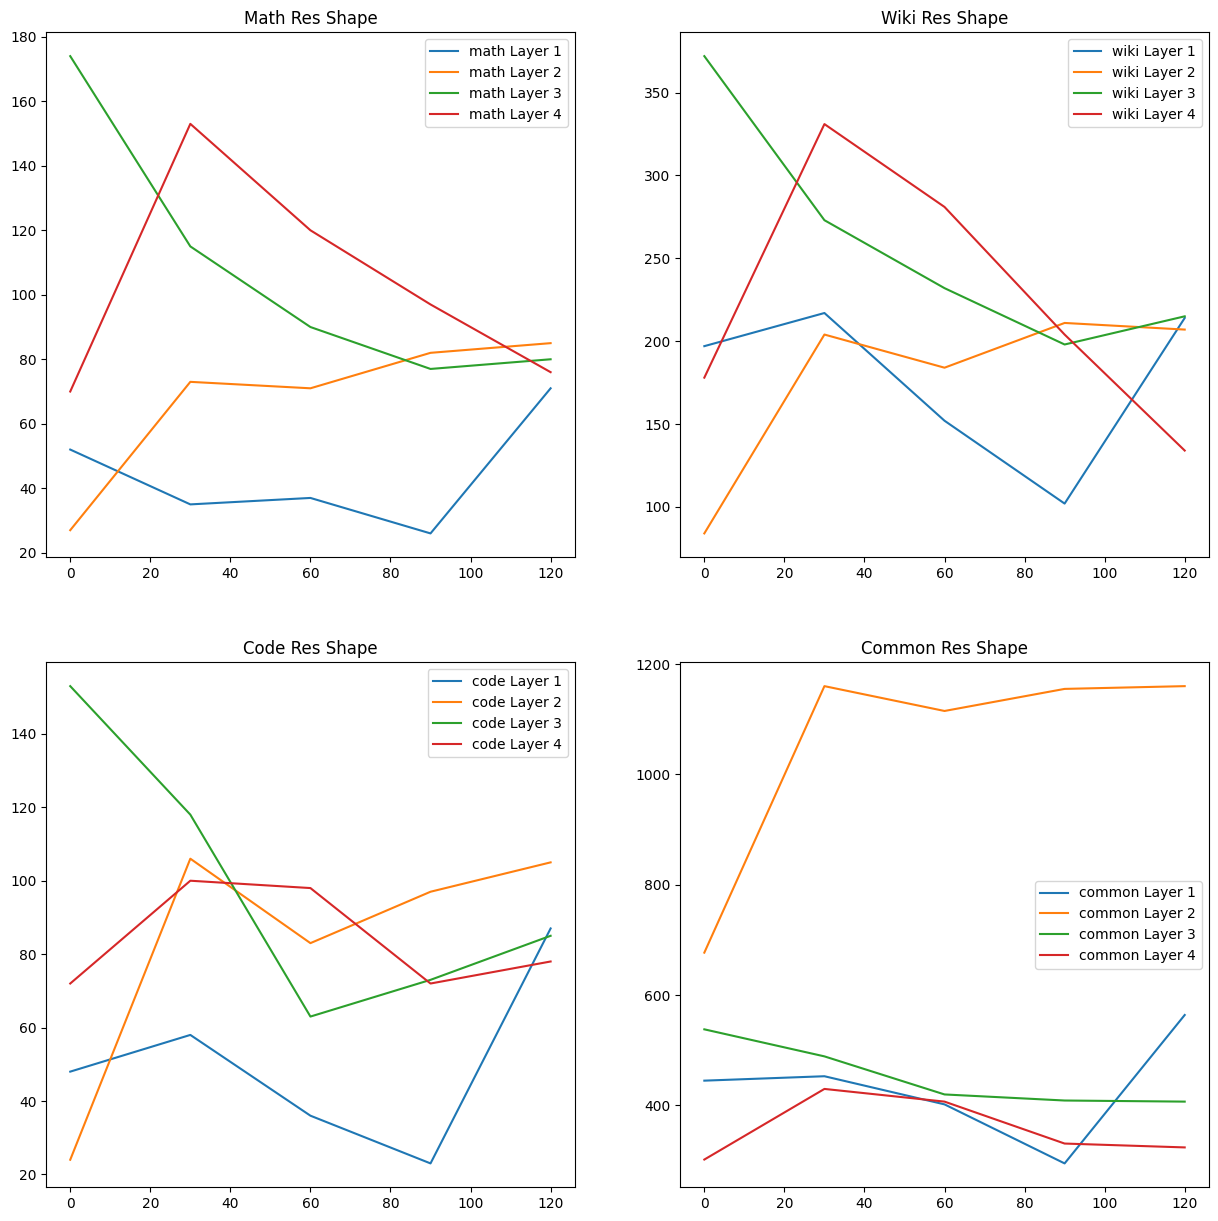

In [15]:
wiki_res_ = [[] for _ in range(layers - 1)]
math_res_ = [[] for _ in range(layers - 1)]
code_res_ = [[] for _ in range(layers - 1)]
common_res_ = [[] for _ in range(layers - 1)]

threshold = 1e-5
top_num = 2000
for layer in range(layers - 2):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 1], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 1], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki, nz_all[layer][idx].nonzero().view(-1).cpu().numpy()
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math, nz_all[layer][idx].nonzero().view(-1).cpu().numpy()
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code, nz_all[layer][idx].nonzero().view(-1).cpu().numpy()
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index, nz_all[layer][idx].nonzero().view(-1).cpu().numpy()
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(layers - 2):
    axs[0, 0].plot(
        np.arange(0, 150, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(layers - 2):
    axs[0, 1].plot(
        np.arange(0, 150, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(layers - 2):
    axs[1, 0].plot(
        np.arange(0, 150, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(layers - 2):
    axs[1, 1].plot(
        np.arange(0, 150, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

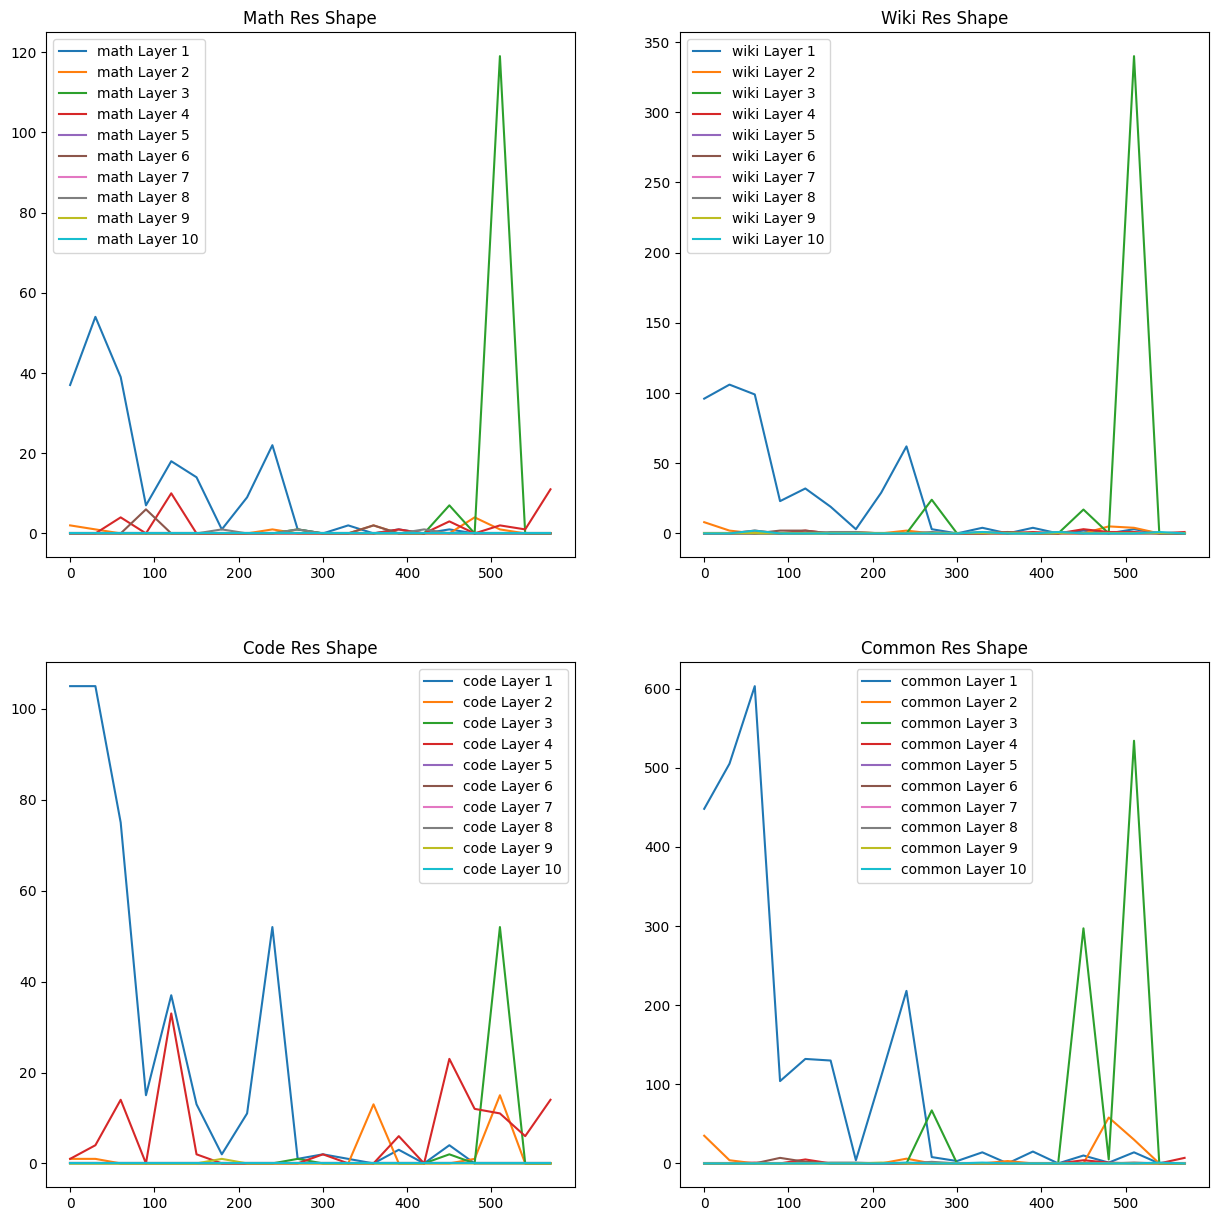

In [20]:
wiki_res_ = [[] for _ in range(layers - 1)]
math_res_ = [[] for _ in range(layers - 1)]
code_res_ = [[] for _ in range(layers - 1)]
common_res_ = [[] for _ in range(layers - 1)]

threshold = 1e-4
top_num = 2000
for layer in range(layers - 2):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 1], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 1], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(layers - 2):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(layers - 2):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(layers - 2):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(layers - 2):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

In [41]:
import copy
import datasets
model_name = "gemma-2-2b"
model = sae_lens.HookedSAETransformer.from_pretrained(
        model_name, dtype=torch.bfloat16
    )
nz_all = []
doc_len = 0
freq_mean_global = 0
layers = 26
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 5
ds = datasets.load_dataset("b-mc2/sql-create-context")["train"]
saes = []
release = "gemma-scope-2b-pt-res-canonical"
for layer in tqdm(range(layers)):
    sae_id = f"layer_{layer}/width_16k/canonical"
    sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]
    sae.to(dtype=torch.bfloat16)
    saes.append(sae)
model = sae_lens.HookedSAETransformer.from_pretrained(
    model_name, dtype=torch.bfloat16
)
for layer in range(layers - 1):
    sae_id = f"layer_{layer}/width_16k/canonical"
    sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]
    saes = [sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]]
    sae_id = f"layer_{layer+1}/width_16k/canonical"
    sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]
    saes.append(sae)
    nz_freqs = []
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        sae_id = f"layer_{layer}/width_16k/canonical"
        sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]
        saes2 = [sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]]
        sae_id = f"layer_{layer+1}/width_16k/canonical"
        sae = sae_lens.SAE.from_pretrained(release, sae_id, device="cuda")[0]
        saes2.append(sae)
        with torch.no_grad():
            abl_num = 30
            list(
                map(
                    lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(),
                    top_index_wiki[abl_num * idx : abl_num * (idx + 1)],
                )
            )
        ds_ratio = 1e-4
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["answer"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(
                tokens, saes=saes, use_error_term=False
            )
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(
                tokens, saes=saes2, use_error_term=False
            )
            model.reset_saes()
            local_doc_len = cache1[f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"].shape[
                1
            ]
            freq = torch.zeros_like(freqs)

            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (
                abs(((cache1[prompt2] > 1e-3) + 0 + (cache2[prompt2] > 1e-3) - 1))
                < 1e-2
            )[0].sum(0) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Loaded pretrained model gemma-2-2b into HookedTransformer


Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Loaded pretrained model gemma-2-2b into HookedTransformer


 80%|████████  | 4/5 [01:21<00:20, 20.26s/it]


KeyboardInterrupt: 

In [45]:
freq_mean_global.nonzero().shape

torch.Size([219, 1])

In [53]:
data_name = "wiki"
if data_name == "wiki":
    dataset = datasets.load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")[
        "train"
    ]
    text = "text"
    if model_name == "gemma2":
        ds_ratio = 5e-3
    elif model_name == "llama3":
        ds_ratio = 5e-3
    else:
        ds_ratio = 5e-3
elif data_name == "code":
    dataset = datasets.load_dataset("b-mc2/sql-create-context")["train"]
    text = "answer"
    if model_name == "gemma2":
        ds_ratio = 5e-4
    elif model_name == "llama3":
        ds_ratio = 5e-4
    else:
        ds_ratio = 5e-4
elif data_name == "math":
    dataset = datasets.load_dataset("TIGER-Lab/MathInstruct")["train"]
    text = "output"
    if model_name == "gemma2":
        ds_ratio = 1e-4
    elif model_name == "llama3":
        ds_ratio = 1e-4
    else:
        ds_ratio = 1e-4
length_ds = int(len(dataset) * ds_ratio)
    

In [55]:
print(int(len(dataset) * 5e-3))

183


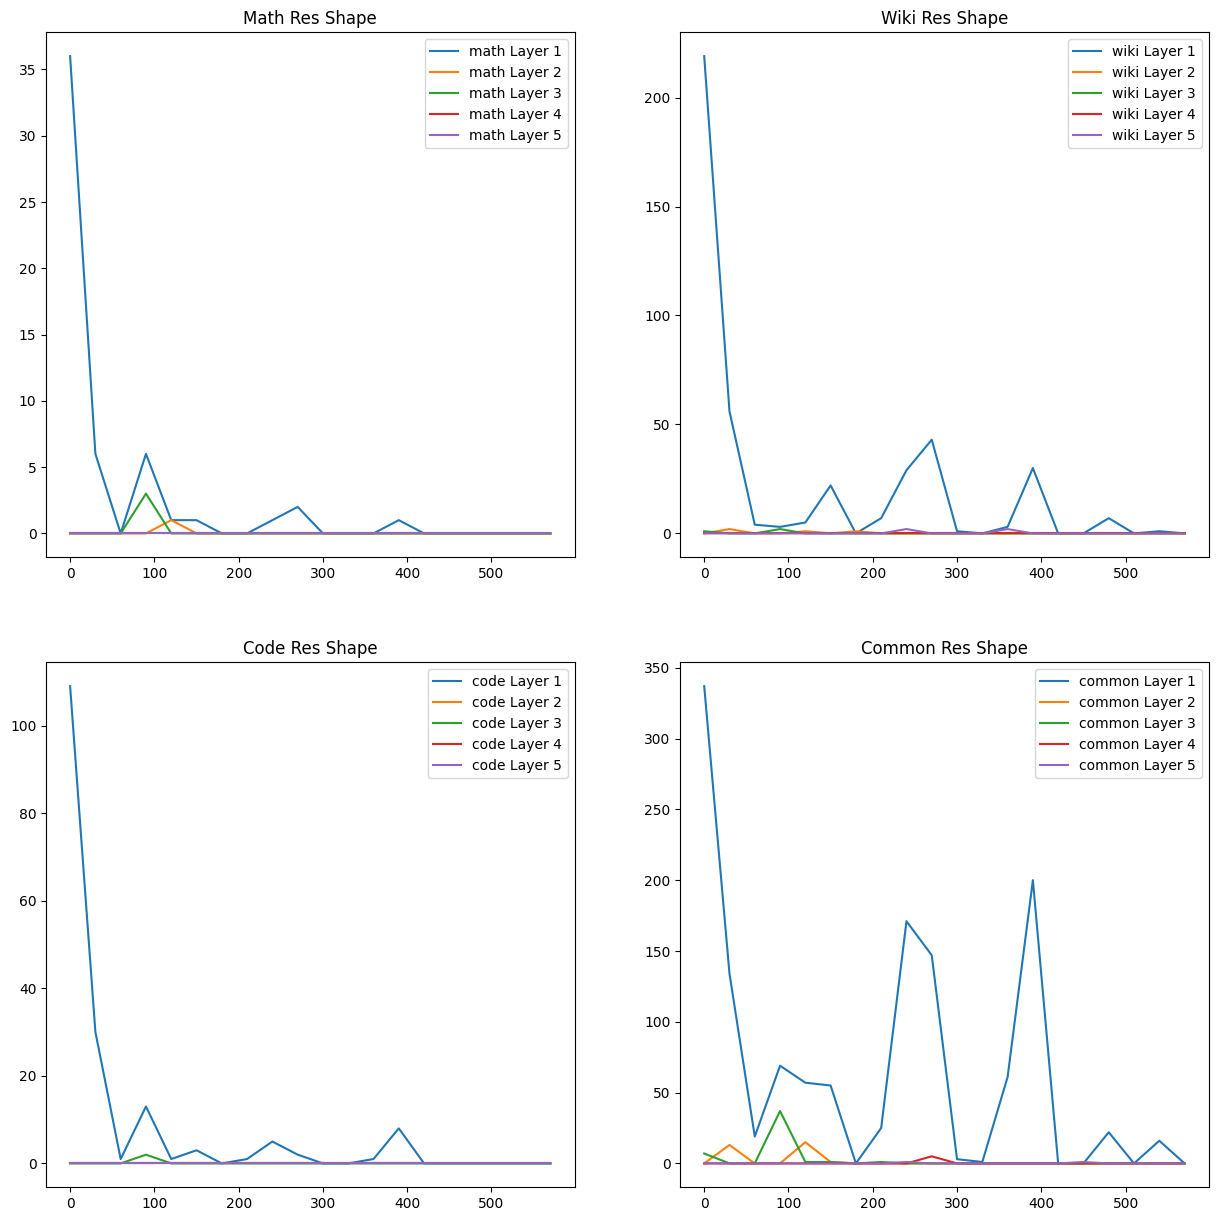

In [54]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-4

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

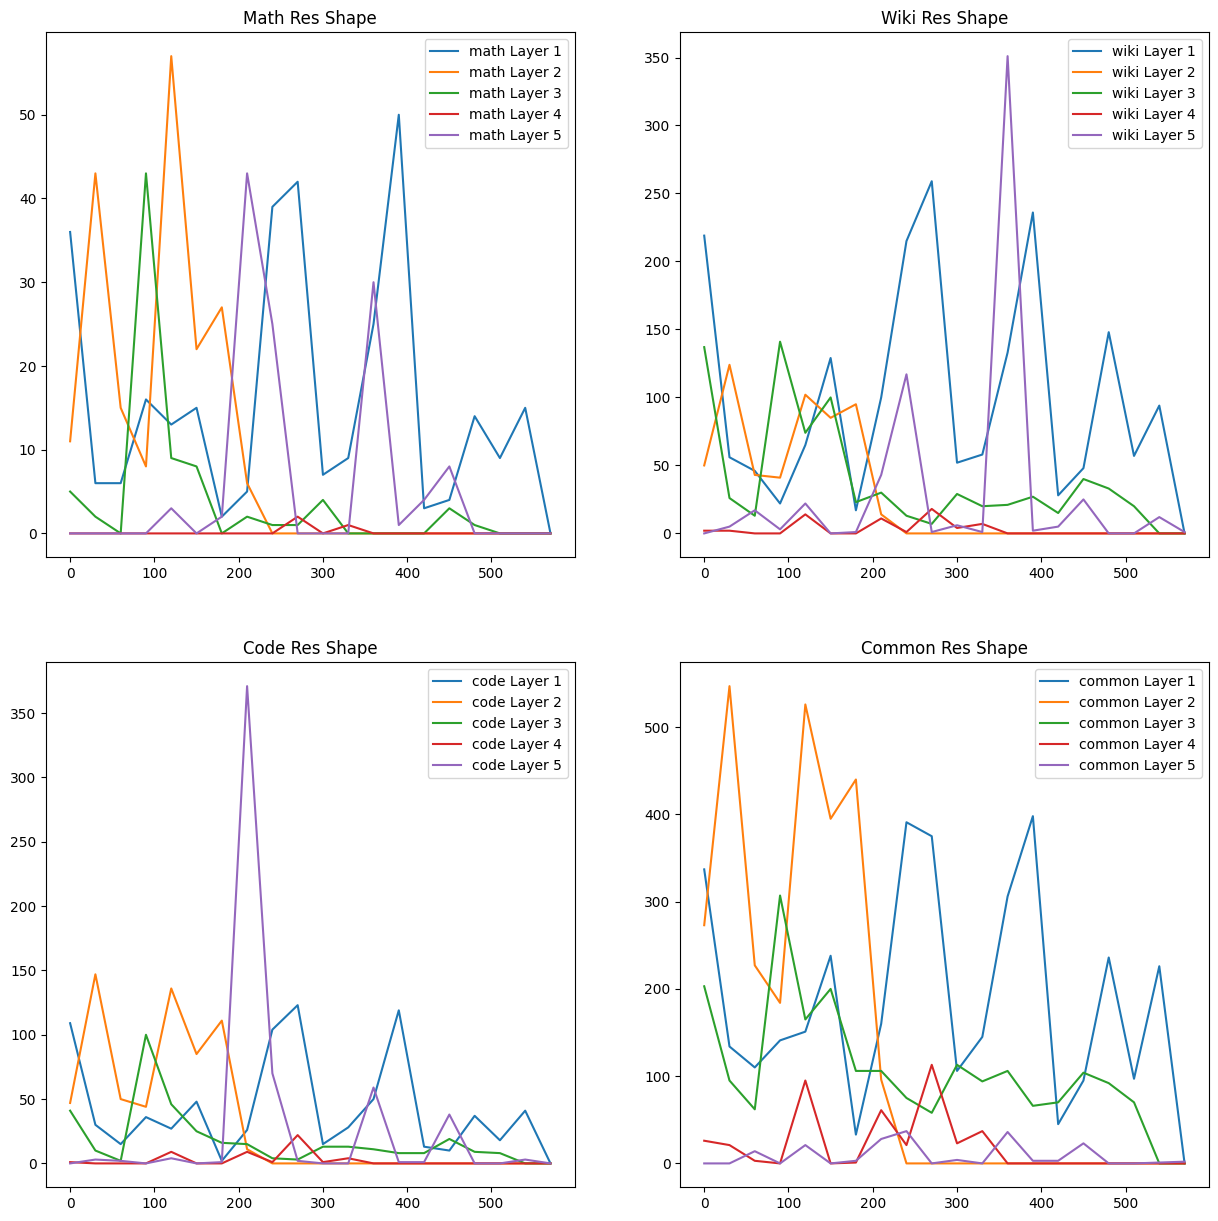

In [55]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-5

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

In [57]:
nz_all[layer][idx].nonzero()

tensor([[   24],
        [  131],
        [  151],
        ...,
        [32683],
        [32736],
        [32755]], device='cuda:0')

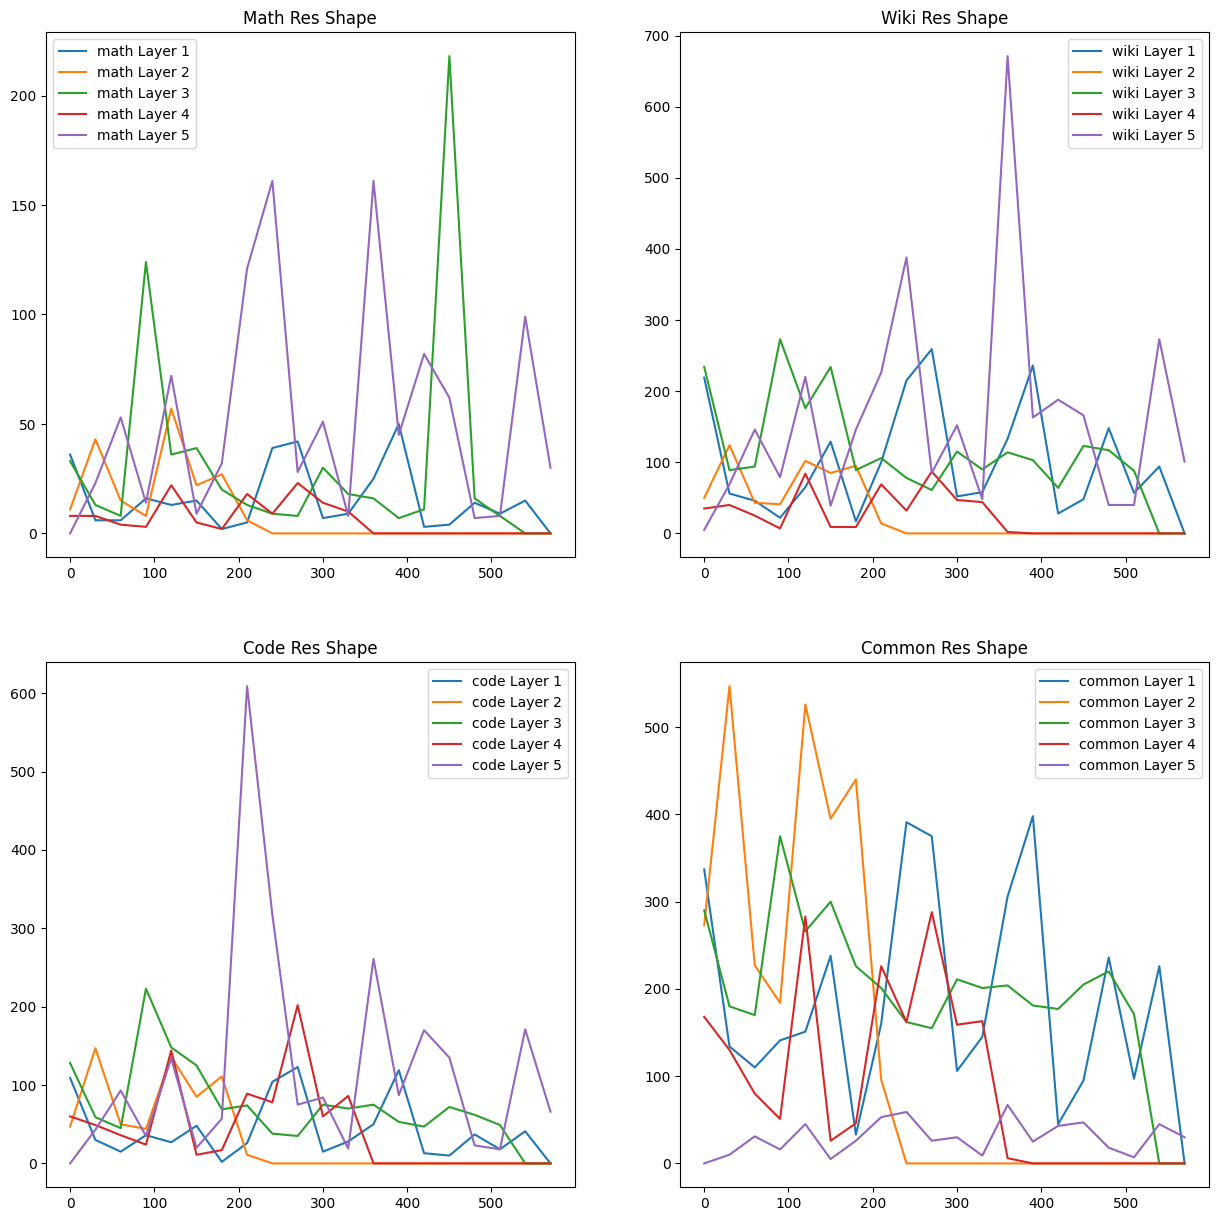

In [59]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-5

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki, (nz_all[layer][idx]).nonzero().view(-1).cpu().numpy()
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math, (nz_all[layer][idx].nonzero().view(-1).cpu().numpy())
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code, (nz_all[layer][idx].nonzero().view(-1).cpu().numpy())
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index, (nz_all[layer][idx].nonzero().view(-1).cpu().numpy())
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

In [75]:
math_dataset = datasets.load_dataset("hbin0701/abstract_math")["train"]["input"]

In [84]:
code_dataset

Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 25443
})

In [86]:
import copy

nz_all = []
doc_len = 0
freq_mean_global = 0
top_num = 1800
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 20
for layer in range(layers - 1):
    nz_freqs = []
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 30
            list(
                map(
                    lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(),
                    top_index_code[abl_num * idx : abl_num * (idx + 1)],
                )
            )
        ds_ratio = 1e-4
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = code_dataset[idx]
            tokens = model.to_tokens([example["solutions"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(
                tokens, saes=saes, use_error_term=False
            )
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(
                tokens, saes=saes2, use_error_term=False
            )
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[
                1
            ]
            freq = torch.zeros_like(freqs)

            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (
                abs(((cache1[prompt2] > 1e-3) + 0 + (cache2[prompt2] > 1e-3) - 1))
                < 1e-2
            )[0].sum(0) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 20/20 [01:48<00:00,  5.40s/it]


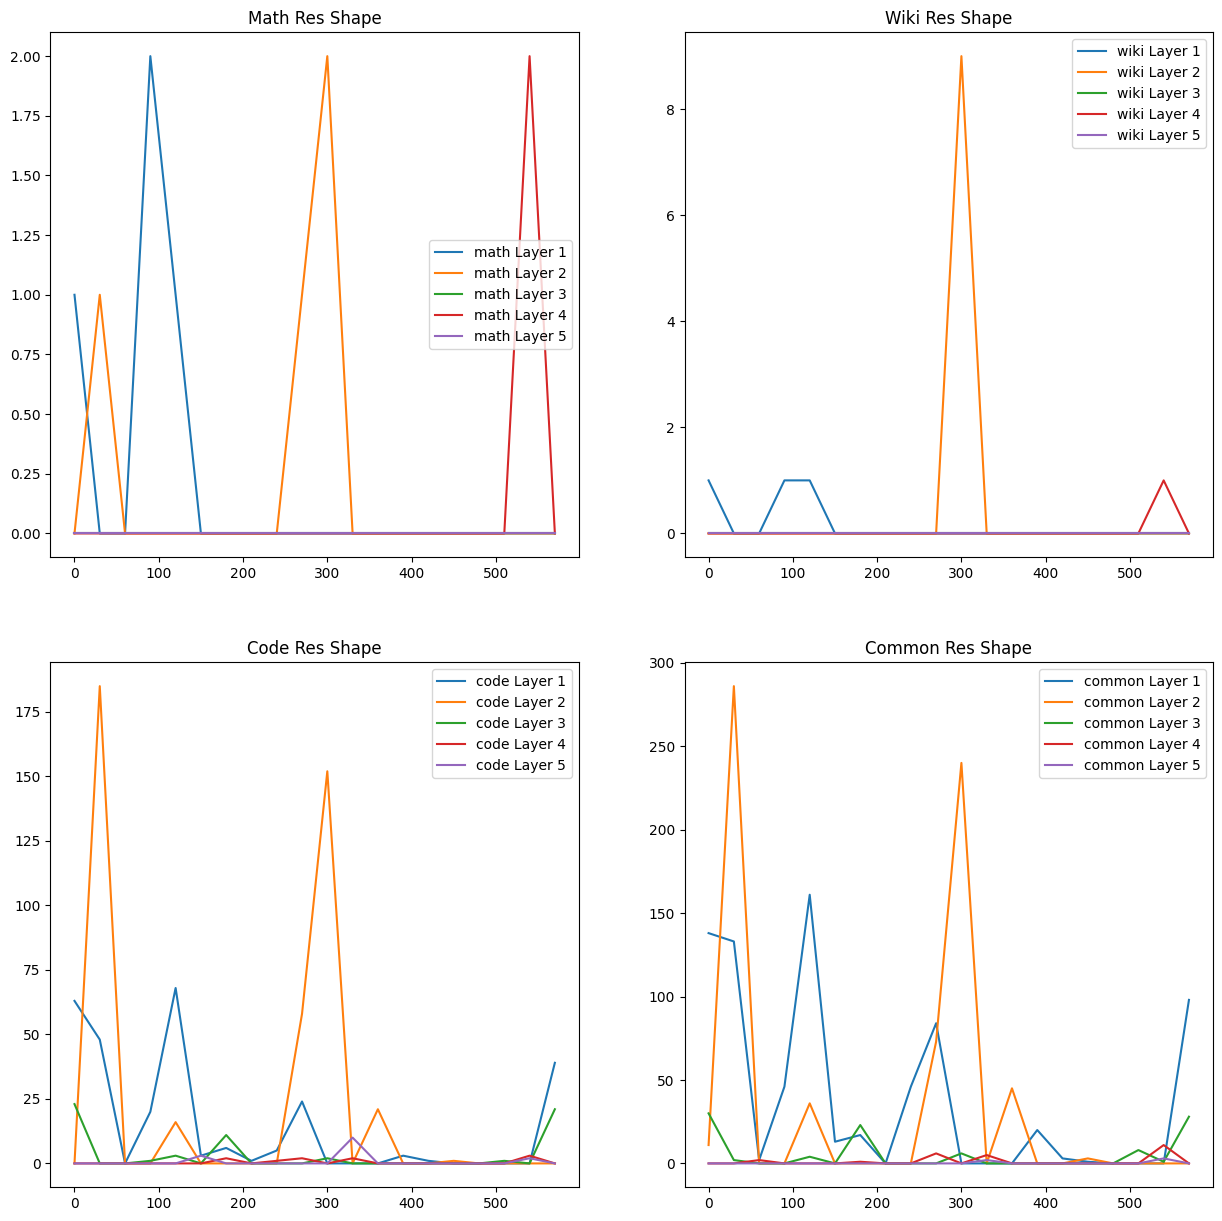

In [88]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-4

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

In [89]:
import copy

nz_all = []
doc_len = 0
freq_mean_global = 0
top_num = 1800
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 20
for layer in range(layers - 1):
    nz_freqs = []
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 30
            list(
                map(
                    lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(),
                    top_index_math[abl_num * idx : abl_num * (idx + 1)],
                )
            )
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = math_dataset[idx]
            tokens = model.to_tokens([example], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(
                tokens, saes=saes, use_error_term=False
            )
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(
                tokens, saes=saes2, use_error_term=False
            )
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[
                1
            ]
            freq = torch.zeros_like(freqs)

            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (
                abs(((cache1[prompt2] > 1e-3) + 0 + (cache2[prompt2] > 1e-3) - 1))
                < 1e-2
            )[0].sum(0) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


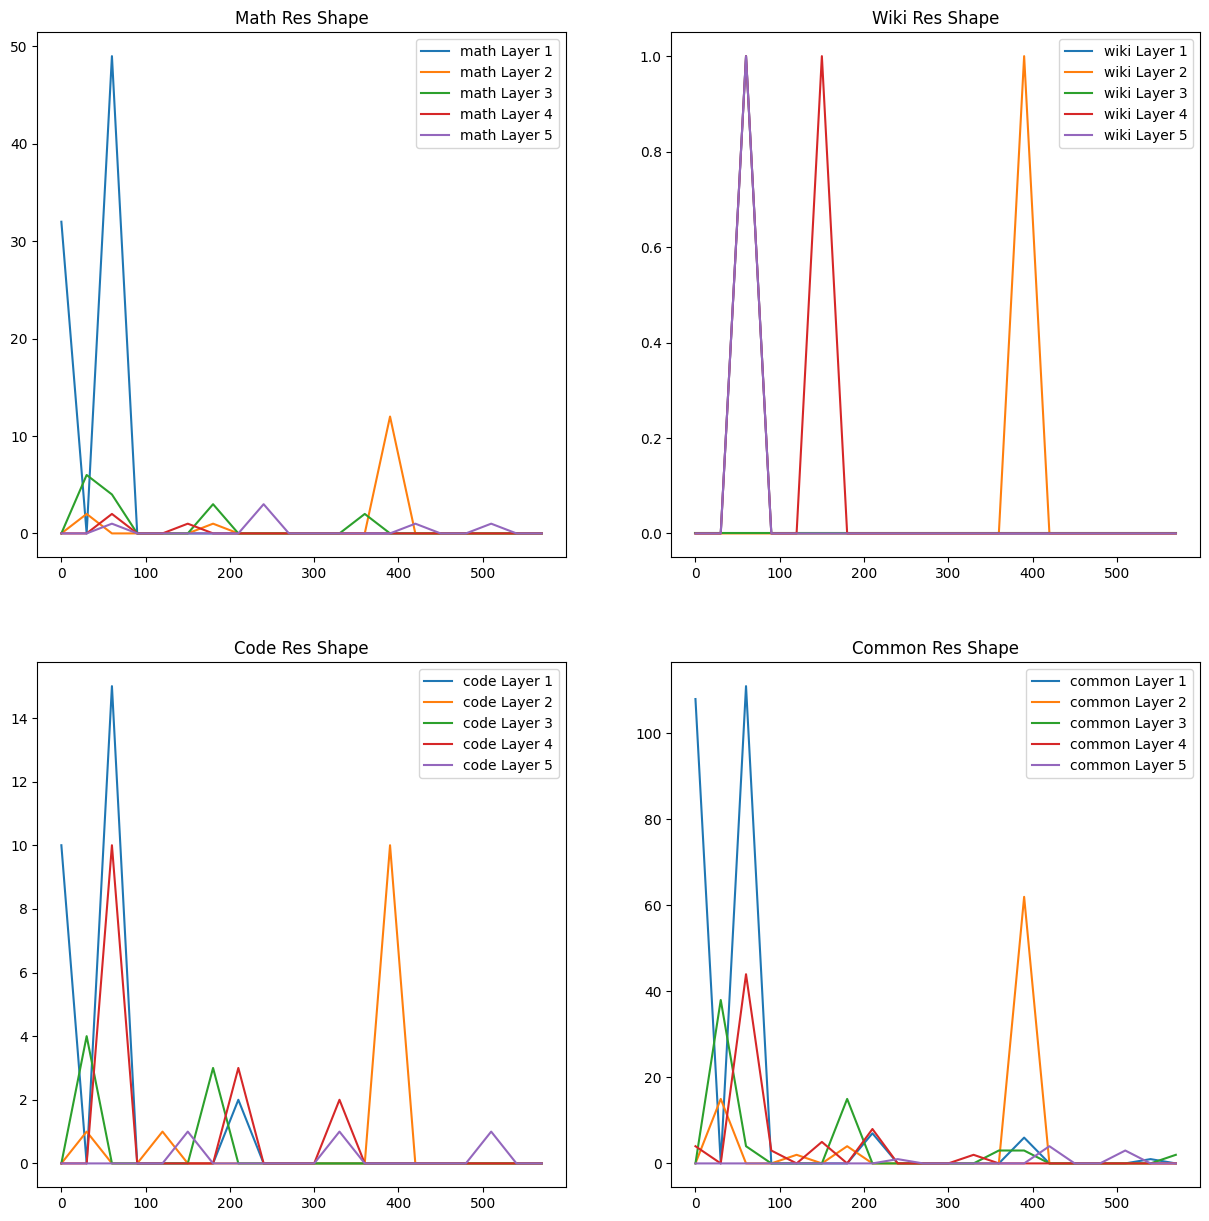

In [91]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-3

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

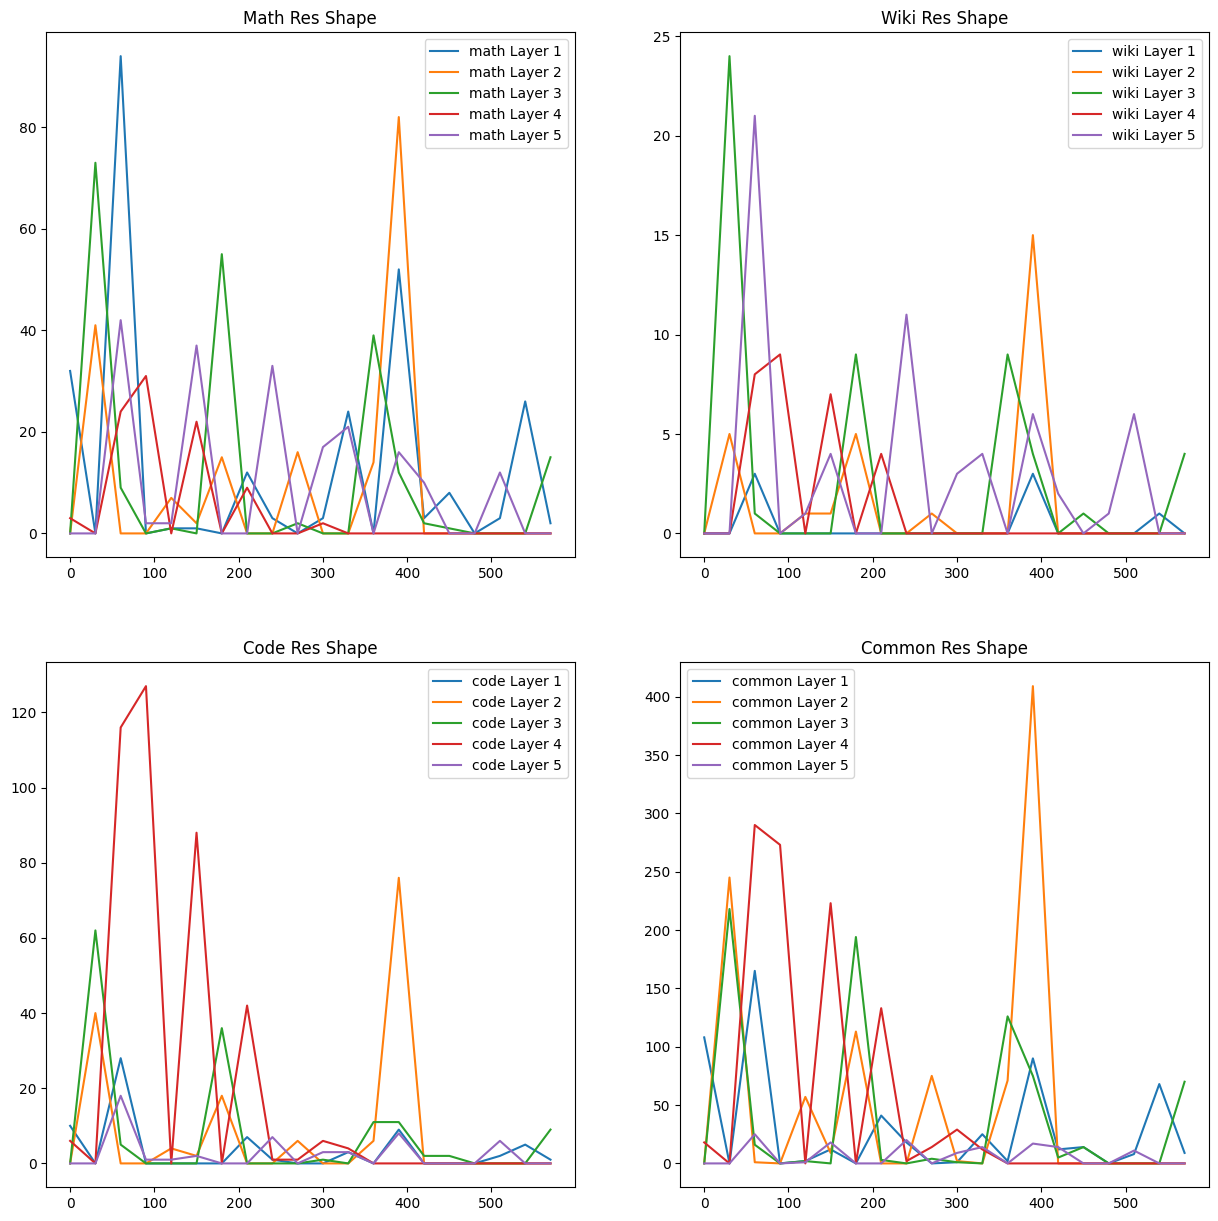

In [83]:
wiki_res_ = [[], [], [], [], []]
math_res_ = [[], [], [], [], []]
code_res_ = [[], [], [], [], []]
common_res_ = [[], [], [], [], []]
threshold = 1e-5

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], top_num).indices
    top_index_math = torch.topk(math_acts[layer + 2], top_num).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], top_num).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):
        wiki_res_[layer].append(
            np.intersect1d(
                top_index_wiki,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        math_res_[layer].append(
            np.intersect1d(
                top_index_math,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        code_res_[layer].append(
            np.intersect1d(
                top_index_code,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )
        common_res_[layer].append(
            np.intersect1d(
                top_index,
                (nz_all[layer][idx] > threshold).nonzero().view(-1).cpu().numpy(),
            )
        )

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

wiki_res_shape = []
math_res_shape = []
code_res_shape = []
common_res_shape = []
for layer in range(layers - 1):
    wiki_res_shape.append([len(x) for x in wiki_res_[layer]])
    math_res_shape.append([len(x) for x in math_res_[layer]])
    code_res_shape.append([len(x) for x in code_res_[layer]])
    common_res_shape.append([len(x) for x in common_res_[layer]])
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for layer in range(5):
    axs[0, 0].plot(
        np.arange(0, 600, 30), math_res_shape[layer], label=f"math Layer {layer+1}"
    )
axs[0, 0].legend()
axs[0, 0].set_title("Math Res Shape")

for layer in range(5):
    axs[0, 1].plot(
        np.arange(0, 600, 30), wiki_res_shape[layer], label=f"wiki Layer {layer+1}"
    )
axs[0, 1].legend()
axs[0, 1].set_title("Wiki Res Shape")

for layer in range(5):
    axs[1, 0].plot(
        np.arange(0, 600, 30), code_res_shape[layer], label=f"code Layer {layer+1}"
    )
axs[1, 0].legend()
axs[1, 0].set_title("Code Res Shape")

for layer in range(5):
    axs[1, 1].plot(
        np.arange(0, 600, 30), common_res_shape[layer], label=f"common Layer {layer+1}"
    )
axs[1, 1].legend()
axs[1, 1].set_title("Common Res Shape")

plt.show()

In [33]:
import copy

nz_all = []
top_num = 600
top_index_wiki = torch.topk(wiki_acts, top_num).indices
doc_len = 0
freq_mean_global = 0
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 19
for layer in range(layers - 1):
    nz_freqs = []
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 29
            list(
                map(
                    lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(),
                    top_index_wiki[0][abl_num * idx : abl_num * (idx + 1)],
                )
            )
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["text"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(
                tokens, saes=saes, use_error_term=False
            )
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(
                tokens, saes=saes2, use_error_term=False
            )
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[
                1
            ]
            freq = torch.zeros_like(freqs)

            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (((cache1[prompt2] > 1e-3) + 0 + cache2[prompt2] > 1e-3) == 1)[
                0
            ].sum(0) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


In [45]:
top_index_wiki = torch.topk(wiki_acts, top_num).indices

res_ = [[], [], [], [], []]

for layer in range(layers - 1):
    top_index_code = torch.topk(code_acts[layer + 1], 325).indices
    top_index_math = torch.topk(math_acts[layer + 2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 325).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in range(len(nz_freqs)):

        res = np.intersect1d(
            top_index_wiki[layer + 2].cpu().numpy(),
            nz_all[layer][idx].nonzero().view(-1).cpu().numpy(),
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (324,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([80

In [49]:
res_ = [[], [], [], [], []]
top_num = 325
top_index_wiki = torch.topk(wiki_acts, top_num).indices

# TODO: use more top abl, and more datasets, add more group index
for layer in range(layers - 1):
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(
            top_index_wiki[layer + 2].cpu().numpy(),
            (nz_all[layer][idx] > 1e-3).nonzero().view(-1).cpu().numpy(),
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)

last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (324,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (322,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (321,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (320,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (316,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (312,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (305,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (301,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (297,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (296,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (293,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (289,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (287,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (282,) abl_layer: 0 influence freq: torch.Size([80

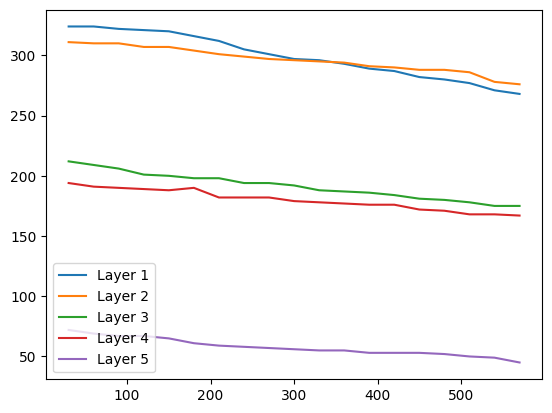

In [52]:
import matplotlib.pyplot as plt
import numpy as np

res_shape = [[], [], [], [], []]
for layer in range(5):
    for idx in range(len(res_[layer])):
        res_shape[layer].append(res_[layer][idx].shape)
for layer in range(5):
    plt.plot(np.arange(30, 600, 30), res_shape[layer], label=f"Layer {layer+1}")
plt.legend()
# plt.title('common feature influence(>1e-3) on high freq vector')
plt.show()
# plt.savefig("../../res/ablation/abl_low_high_perb_math_pythia_common_res_post.png")

In [39]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer + 1], 325).indices
    top_index_math = torch.topk(math_acts[layer + 2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 325).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(
            top_index_wiki, (nz_all[layer][idx] > 1e-3).nonzero().view(-1).cpu().numpy()
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (94,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (93,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (93,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (92,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (92,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (90,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (89,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (89,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (87,) abl_layer: 0 influence freq: torch.Size([8042])
common iou

In [40]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer + 1], 325).indices
    top_index_math = torch.topk(math_acts[layer + 2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 325).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(
            top_index, (nz_all[layer][idx] > 1e-3).nonzero().view(-1).cpu().numpy()
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (25,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8042])
common iou

In [53]:
import copy

nz_all = []
top_num = 600
top_index_wiki = torch.topk(wiki_acts, top_num).indices
doc_len = 0
freq_mean_global = 0
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 10
for layer in range(layers - 1):
    nz_freqs = []
    abl_layer = layer
    top_index_code = torch.topk(code_acts[layer + 1], 600).indices
    top_index_math = torch.topk(math_acts[layer + 2], 600).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 600).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 29
            list(
                map(
                    lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(),
                    top_index_wiki[abl_num * idx : abl_num * (idx + 1)],
                )
            )
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["text"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(
                tokens, saes=saes, use_error_term=False
            )
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(
                tokens, saes=saes2, use_error_term=False
            )
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[
                1
            ]
            freq = torch.zeros_like(freqs)

            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (((cache1[prompt2] > 1e-3) + 0 + cache2[prompt2] > 1e-3) == 1)[
                0
            ].sum(0) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [57]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer + 1], 325).indices
    top_index_math = torch.topk(math_acts[layer + 2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 325).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(
            top_index_wiki, (nz_all[layer][idx] > 1e-1).nonzero().view(-1).cpu().numpy()
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (12,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (4,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8059])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8084])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7002])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([6999])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7000])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (0,) abl_lay

In [55]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer + 1], 325).indices
    top_index_math = torch.topk(math_acts[layer + 2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer + 2], 325).indices
    top_index_mc = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_math.cpu().numpy()
    )
    top_index_mw = np.intersect1d(
        top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index_cw = np.intersect1d(
        top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy()
    )
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(
        top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw)
    )
    top_index_math = np.setdiff1d(
        top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw)
    )
    top_index_code = np.setdiff1d(
        top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw)
    )
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(
            top_index, (nz_all[layer][idx] > 1e-3).nonzero().view(-1).cpu().numpy()
        )
        print(
            f"common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}"
        )
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (25,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8059])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8084])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7002])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([6999])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7000])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (7,

In [68]:
torch.load("../res/acts/abl/llama3_math_layer0_abl0_loss_topcode.pt").nonzero().shape

/tmp/ipykernel_20718/3877068781.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../res/acts/abl/llama3_math_layer0_abl0_loss_topcode.pt").nonzero().shape


torch.Size([131, 1])

In [67]:
data_name = "code"
if data_name == "wiki":
    dataset = datasets.load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")[
        "train"
    ]
    text = "text"
    ds_ratio = 3e-3
elif data_name == "code":
    dataset = datasets.load_dataset("b-mc2/sql-create-context")["train"]
    text = "answer"
    ds_ratio = 1e-3
elif data_name == "math":
    dataset = datasets.load_dataset("TIGER-Lab/MathInstruct")["train"]
    text = "output"
    ds_ratio = 5e-4
print(len(dataset)*ds_ratio)    

78.577
